In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import datetime
from data_handler import data_handler

cvxopt.solvers.options['show_progress'] = False


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
tickers = ['WMT', 'XOM', 'IBM', 'GE']
start_date = '2012-12-31'
end_date = '2013-12-31'
raw_data = data_handler.main(tickers, start_date, end_date, freq='weekly')
data = {}
dates = []
first = True
for ticker in raw_data.keys():
    data[ticker] = []
    for row in sorted(raw_data[ticker], key=lambda x: datetime.datetime.strptime(x['Date'], '%Y-%m-%d')):
        if first:
            dates.append(datetime.datetime.strptime(row['Date'], '%Y-%m-%d').date())
        data[ticker].append(float(row['Adj_Close']))
    first = False

Found in cache!!!
Found in cache!!!
Found in cache!!!
Found in cache!!!


In [3]:
# Compute the returns
returns = {}
for ticker, points in data.items():
    returns[ticker] = np.array([points[i]/points[i-1] for i in range(1, len(points))])

In [4]:
keys = sorted(returns.keys())

def compute_mu_sigma(allocations):
    current_returns = np.zeros(len(dates)-1)
    for i in range(len(keys)):
        current_returns += allocations[i]*returns[keys[i]]
    mean = np.mean(current_returns)
    std = np.std(current_returns, ddof=1)
    return mean, std

def generate_random_portfolio():
    N = len(keys)
    allocations = np.random.rand(N)
    allocations /= sum(allocations)
    return allocations
    

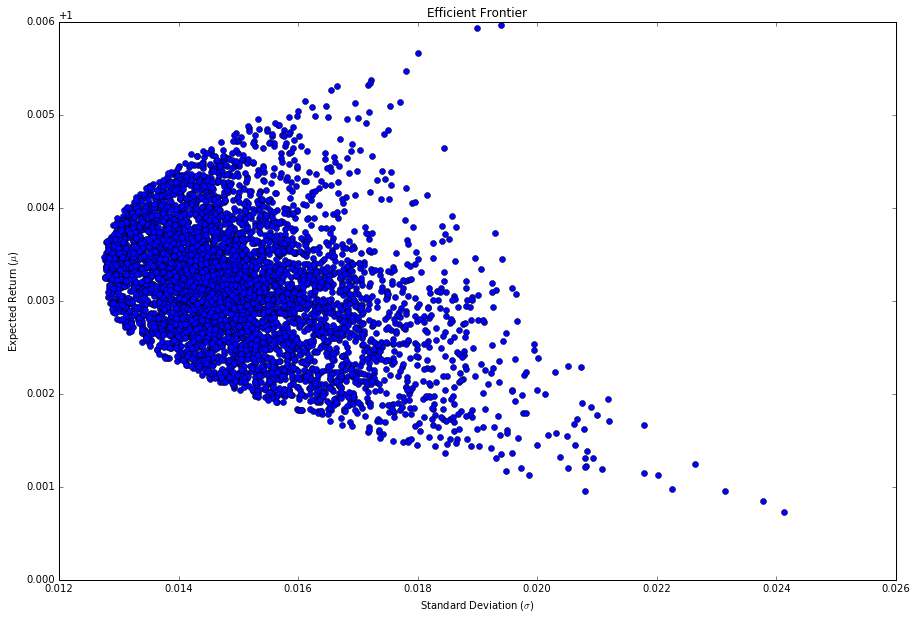

In [5]:
num_portfolios = 5000
np.random.seed(1)

means, stds = np.column_stack([compute_mu_sigma(generate_random_portfolio()) for _ in range(num_portfolios)])

fig = plt.figure(figsize=(15,10))

plt.plot(stds, means, 'o')

plt.xlabel("Standard Deviation ($\sigma$)")
plt.ylabel("Expected Return ($\mu$)")
plt.title('Efficient Frontier')

plt.show()

In [6]:
def mvo_portfolio(m):
    K = len(keys)
    rets = []
    for key in keys:
        rets.append(returns[key])
    Q = np.cov(rets)
    mu = np.mean(rets, axis=1)
    
    # Assume independently distributed
    G = -1.0 * np.eye(K)
    h = np.zeros((K, 1))
    A = np.ones((1, K))
    b = [1.0]
    
    sol = cvxopt.solvers.qp(
        cvxopt.matrix(m*Q),
        cvxopt.matrix(-1.0*mu),
        cvxopt.matrix(G),
        cvxopt.matrix(h),
        cvxopt.matrix(A),
        cvxopt.matrix(b)
    )
    return sol['x']


In [7]:
# Allocations to achieve a certain portfolio value
allocation = mvo_portfolio(100)
print allocation
print compute_mu_sigma(allocation)

[ 2.18e-01]
[ 3.98e-05]
[ 3.70e-01]
[ 4.13e-01]

(1.0037889352220983, 0.012876648579099923)


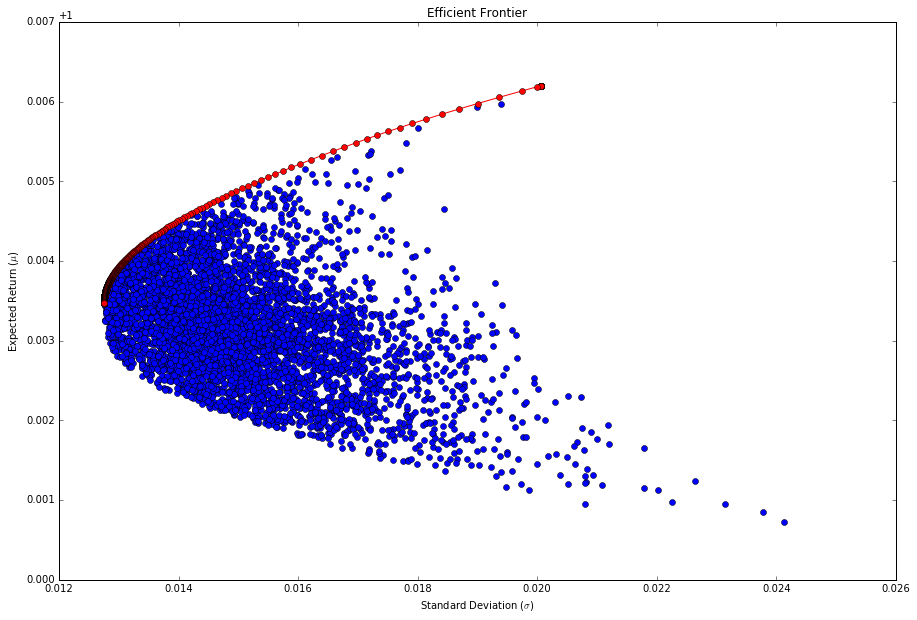

In [9]:
fig = plt.figure(figsize=(15,10))

steps = np.linspace(1, 1000, num=2000)

means1, stds1 = np.column_stack([compute_mu_sigma(mvo_portfolio(s)) for s in steps])


plt.plot(stds, means, 'o')
plt.plot(stds1, means1, 'r-o')

plt.xlabel("Standard Deviation ($\sigma$)")
plt.ylabel("Expected Return ($\mu$)")
plt.title('Efficient Frontier')

plt.show()